In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings('ignore')

In [34]:
#Memeriksa info file untuk melihat missing values dan data type
df_customer = pd.read_csv("F:/RAKAMIN/KALBE/final task/Customer.csv", delimiter=';')
df_product = pd.read_csv("F:/RAKAMIN/KALBE/final task/Product.csv", delimiter=';')
df_store = pd.read_csv("F:/RAKAMIN/KALBE/final task/Store.csv", delimiter=';')
df_transaction = pd.read_csv("F:/RAKAMIN/KALBE/final task/Transaction.csv", delimiter=';')


df_customer.info()
df_product.info()
df_store.info()
df_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      447 non-null    int64 
 1   Age             447 non-null    int64 
 2   Gender          447 non-null    int64 
 3   Marital Status  444 non-null    object
 4   Income          447 non-null    object
dtypes: int64(3), object(2)
memory usage: 17.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ProductID     10 non-null     object
 1   Product Name  10 non-null     object
 2   Price         10 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 368.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      ------------

In [35]:
#Handling missing value
#dari eda di atas, diketahui bahwa_customer memilki 3 missing values di Marital Status
    # --> diisi dengan value berdasarkan case rata-rata usia dan marital status yang telah didapatkan di DBeaver sebelumnya.

#Memeriksa rows dengan missing value
null_marital_status = df_customer[df_customer['Marital Status'].isnull()]
print(null_marital_status)
    
# Define a function 
def fill_marital_status(row):
    if row['Marital Status'] not in ('Married', 'Single') and row['Age'] > 31:
        return 'Married'
    else:
        return 'Single'

# Apply the function to fill missing values
df_customer['Marital Status'] = df_customer.apply(fill_marital_status, axis=1)
df_customer.info()

     CustomerID  Age  Gender Marital Status Income
9            10   34       1            NaN      4
415         416   27       1            NaN   3,43
442         443   33       1            NaN   9,28
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      447 non-null    int64 
 1   Age             447 non-null    int64 
 2   Gender          447 non-null    int64 
 3   Marital Status  447 non-null    object
 4   Income          447 non-null    object
dtypes: int64(3), object(2)
memory usage: 17.6+ KB


In [36]:
#Just to make sure the function has worked well
# List of customer IDs to check
customer_ids_to_check = [10, 416, 443]

# Filter dan print marital status yang baru
marital_status_check = df_customer[df_customer['CustomerID'].isin(customer_ids_to_check)][['CustomerID', 'Age','Marital Status']]
print(marital_status_check)

     CustomerID  Age Marital Status
9            10   34        Married
415         416   27         Single
442         443   33        Married


In [37]:
#Memeriksa Data Duplikat

#Kolom kunci penentuan duplicate row ada pada TransactionID sebagai nilai unik, jadi perlu dicek duplikatnya
df_transaction['TransactionID'].value_counts()

TR71313    3
TR42197    2
TR90402    2
TR74019    2
TR49649    2
          ..
TR29792    1
TR23081    1
TR1691     1
TR98388    1
TR85684    1
Name: TransactionID, Length: 4908, dtype: int64

In [38]:
#memeriksa isi data duplikat
df_transaction[df_transaction['TransactionID']=='TR71313']

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
1982,TR71313,117,21/05/2022,P1,8800,10,88000,8
3336,TR71313,401,30/08/2022,P3,7500,6,45000,11
3722,TR71313,370,26/09/2022,P3,7500,2,15000,3


In [39]:
#Hasil menunjukkan bahwa duplikasi hanya pada kolom transactionid saja, lainnya berbeda.
    #Hal ini mungkin karena transactionid digenerate dari store yang berbeda. 
    #Sehingga datanya masih valid dan dipertahankan 

In [40]:
#DATA INTEGRATION

#Data akan lebih mudah diidentifikasi untuk data cleansing dan transformation ketika sudah disatukan. 
#Oleh karena itu, dilakukan merge ke-empat data tsb lebih dahulu

#MERGE THE DATA
df_merge = pd.merge(df_transaction, df_customer, on=["CustomerID"])
df_merge = pd.merge(df_merge, df_product.drop(columns=['Price']), on=["ProductID"])
df_merge = pd.merge(df_merge, df_store, on=["StoreID"])

df_merge.info()
df_merge.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5020 entries, 0 to 5019
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   TransactionID   5020 non-null   object
 1   CustomerID      5020 non-null   int64 
 2   Date            5020 non-null   object
 3   ProductID       5020 non-null   object
 4   Price           5020 non-null   int64 
 5   Qty             5020 non-null   int64 
 6   TotalAmount     5020 non-null   int64 
 7   StoreID         5020 non-null   int64 
 8   Age             5020 non-null   int64 
 9   Gender          5020 non-null   int64 
 10  Marital Status  5020 non-null   object
 11  Income          5020 non-null   object
 12  Product Name    5020 non-null   object
 13  StoreName       5020 non-null   object
 14  GroupStore      5020 non-null   object
 15  Type            5020 non-null   object
 16  Latitude        5020 non-null   object
 17  Longitude       5020 non-null   object
dtypes: int64

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,01/01/2022,P3,7500,4,30000,12,36,0,Single,"10,53",Crackers,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554"
1,TR89318,183,17/07/2022,P3,7500,1,7500,12,27,1,Single,"0,18",Crackers,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554"
2,TR9106,123,26/09/2022,P3,7500,4,30000,12,34,0,Single,"4,36",Crackers,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554"
3,TR4331,335,08/01/2022,P3,7500,3,22500,12,29,1,Single,"4,74",Crackers,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554"
4,TR6445,181,10/01/2022,P3,7500,4,30000,12,33,1,Single,"9,94",Crackers,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554"


In [41]:
#DATA TRANSFORMATION

# Mengubah kolom "Date" ke tipe data datetime
df_merge['Date'] = pd.to_datetime(df_merge['Date'], format='%d/%m/%Y')

# Column customerid, gender, storeid dalam integer, kita ubah ke string/object karena tidak untuk dikalkulasi
columns_to_str = ['CustomerID', 'Gender', 'StoreID']
df_merge[columns_to_str] = df_merge[columns_to_str].astype(str)

# Column income, latitude, longitude dalam object, kita perlu ubah menjadi float dengan mengubah separator koma ke titik juga. 
df_merge['Income'] = df_merge['Income'].str.replace(',', '.').astype(float)
df_merge['Latitude'] = df_merge['Latitude'].str.replace(',', '.').astype(float)
df_merge['Longitude'] = df_merge['Longitude'].str.replace(',', '.').astype(float)


# Print data types untuk mengkonfirmasi transformasi
print(df_merge.dtypes)
print(df_merge.columns)

TransactionID             object
CustomerID                object
Date              datetime64[ns]
ProductID                 object
Price                      int64
Qty                        int64
TotalAmount                int64
StoreID                   object
Age                        int64
Gender                    object
Marital Status            object
Income                   float64
Product Name              object
StoreName                 object
GroupStore                object
Type                      object
Latitude                 float64
Longitude                float64
dtype: object
Index(['TransactionID', 'CustomerID', 'Date', 'ProductID', 'Price', 'Qty',
       'TotalAmount', 'StoreID', 'Age', 'Gender', 'Marital Status', 'Income',
       'Product Name', 'StoreName', 'GroupStore', 'Type', 'Latitude',
       'Longitude'],
      dtype='object')


In [42]:
#MEMBUAT MODEL MACHINE LEARNING

#Grouping data berdasarkan Date dan agregasi Qty
df_regresi = df_merge.groupby(['Date']).agg({
    'Qty': 'sum'
}).reset_index()
print(df_regresi)

          Date  Qty
0   2022-01-01   49
1   2022-01-02   59
2   2022-01-03   63
3   2022-01-04   45
4   2022-01-05   30
..         ...  ...
360 2022-12-27   70
361 2022-12-28   68
362 2022-12-29   42
363 2022-12-30   44
364 2022-12-31   37

[365 rows x 2 columns]


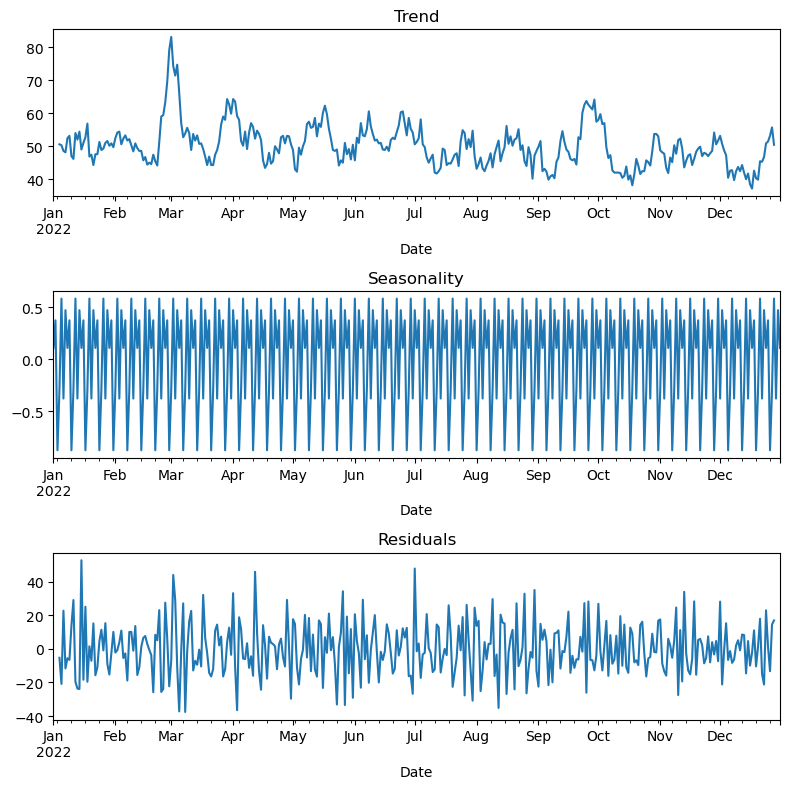

In [43]:
# Perform decomposition
decomposed=seasonal_decompose(df_regresi.set_index('Date'))

# Create subplots for each component
plt.figure(figsize=(8,8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

In [44]:
#test the stationarity, use Augmented Dickey Fuller Test :
test_result = adfuller(df_regresi['Qty'])

# Ho: It is non-stationary
# H1: It is stationary

def adfuller_test(Qty):
    result = adfuller(Qty)
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations']
    for value, label in zip(result, labels):
        print(label + ' : ' + str(value))

adfuller_test(df_regresi['Qty'])

if test_result[1] <= 0.05:
    print("Strong evidence against the null hypothesis (Ho), reject the null hypothesis. Data is stationary.")
else:
    print("Weak evidence against the null hypothesis, indicating it is non-stationary.")


ADF Test Statistic : -19.448086319449082
p-value : 0.0
#Lags Used : 0
Number of Observations : 364
Strong evidence against the null hypothesis (Ho), reject the null hypothesis. Data is stationary.


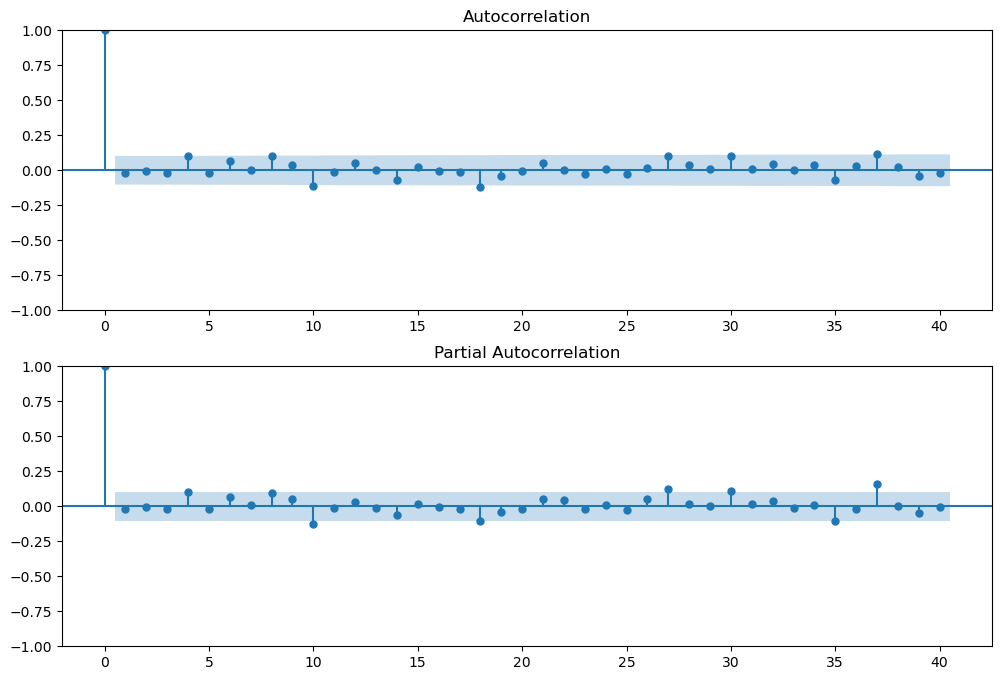

In [45]:
#Membuat plot autocorrelation, acf, pacf
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_regresi['Qty'],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_regresi['Qty'],lags=40,ax=ax2)

In [46]:
#Membagi data menjadi data train dan test
cut_off = round(df_regresi.shape[0] * 0.8)
df_train = df_regresi.iloc[:cut_off]
df_test = df_regresi.iloc[cut_off:].reset_index(drop=True)
train_shape, test_shape = df_train.shape, df_test.shape

print(df_train)
print(df_test)

          Date  Qty
0   2022-01-01   49
1   2022-01-02   59
2   2022-01-03   63
3   2022-01-04   45
4   2022-01-05   30
..         ...  ...
287 2022-10-15   33
288 2022-10-16   26
289 2022-10-17   53
290 2022-10-18   47
291 2022-10-19   34

[292 rows x 2 columns]
         Date  Qty
0  2022-10-20   39
1  2022-10-21   35
2  2022-10-22   56
3  2022-10-23   59
4  2022-10-24   39
..        ...  ...
68 2022-12-27   70
69 2022-12-28   68
70 2022-12-29   42
71 2022-12-30   44
72 2022-12-31   37

[73 rows x 2 columns]


In [47]:
#Set Date as index
df_train = df_train.set_index('Date')
df_test = df_test.set_index('Date')
print(df_test)

            Qty
Date           
2022-10-20   39
2022-10-21   35
2022-10-22   56
2022-10-23   59
2022-10-24   39
...         ...
2022-12-27   70
2022-12-28   68
2022-12-29   42
2022-12-30   44
2022-12-31   37

[73 rows x 1 columns]


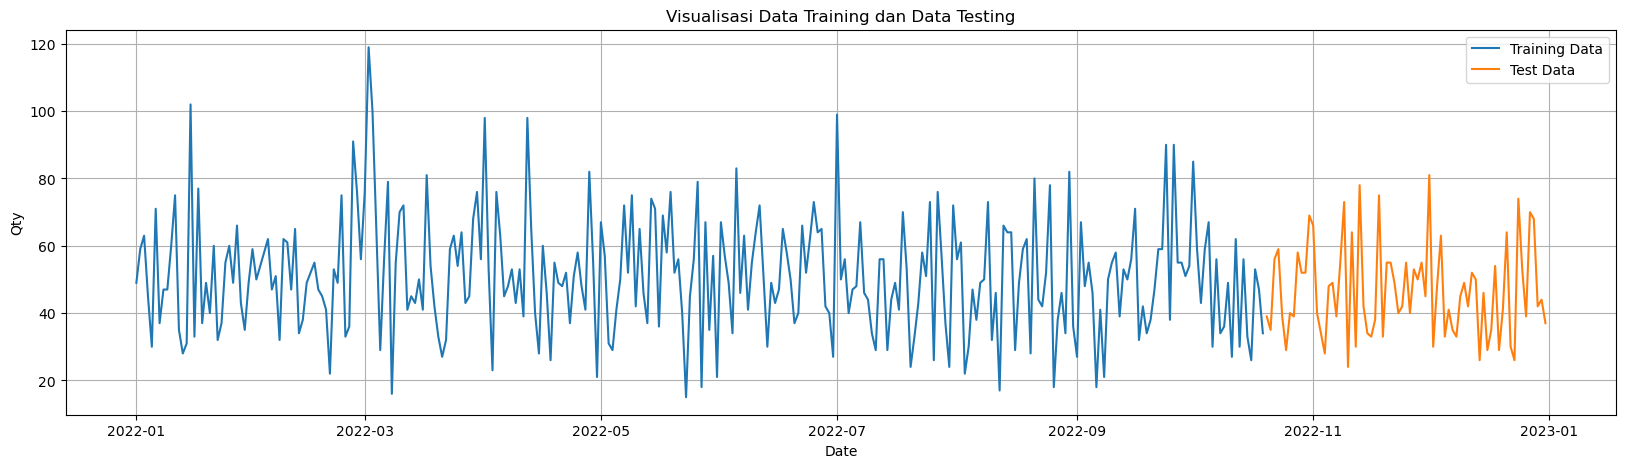

In [48]:
#Visualisasi Data Train dan Data Test
plt.figure(figsize=(20, 5))

# Plot df_train
sns.lineplot(data=df_train, x='Date', y='Qty', label='Training Data')

# Plot df_test 
sns.lineplot(data=df_test, x='Date', y='Qty', label='Test Data')

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Qty')
plt.title('Visualisasi Data Training dan Data Testing')
plt.legend()
plt.grid(True)

plt.show()

Mean Absolute Error: 11.844386956965485
Mean Squared Error: 199.25488973485184
Root Mean Squared Error: 14.11576741572529


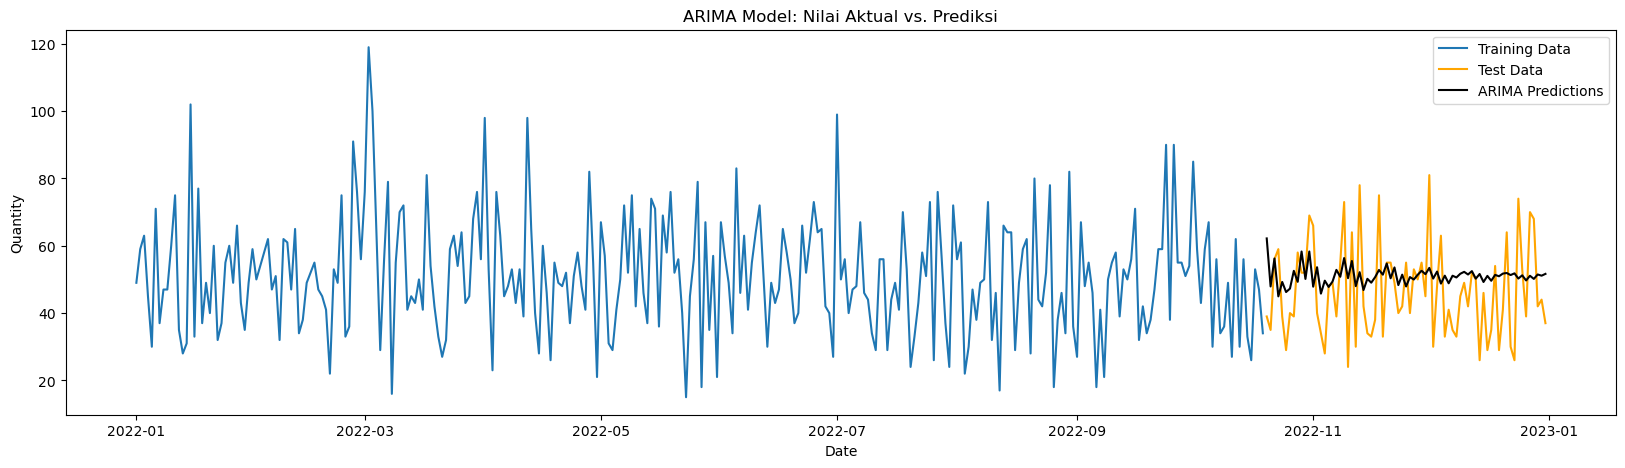

In [49]:
#Membuat plot prediksi

y=df_train['Qty']

ARIMAmodel = ARIMA(y, order=(4, 0, 4))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(df_test))

y_pred_df = y_pred.conf_int()
y_pred_df['predictions'] = ARIMAmodel.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])
y_pred_df.index = df_test.index
y_pred_out = y_pred_df['predictions']

#Menghitung matrix evaluasi
mae = mean_absolute_error(df_test['Qty'], y_pred_out)
mse = mean_squared_error(df_test['Qty'], y_pred_out)
rmse = np.sqrt(mse)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

# Plot the results
plt.figure(figsize=(20, 5))
plt.plot(df_train['Qty'], label='Training Data')
plt.plot(df_test['Qty'], color='orange', label='Test Data')
plt.plot(y_pred_out, color='black', label='ARIMA Predictions')
plt.legend()
plt.title('ARIMA Model: Nilai Aktual vs. Prediksi')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.show()


In [50]:
model = ARIMA(df_regresi['Qty'],order = (4,0,4))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    Qty   No. Observations:                  365
Model:                 ARIMA(4, 0, 4)   Log Likelihood               -1540.859
Date:                Sun, 03 Sep 2023   AIC                           3101.719
Time:                        18:49:25   BIC                           3140.718
Sample:                             0   HQIC                          3117.217
                                - 365                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.1312      1.077     46.543      0.000      48.020      52.242
ar.L1          0.0626      0.331      0.189      0.850      -0.586       0.711
ar.L2         -0.2376      0.313     -0.758      0.4

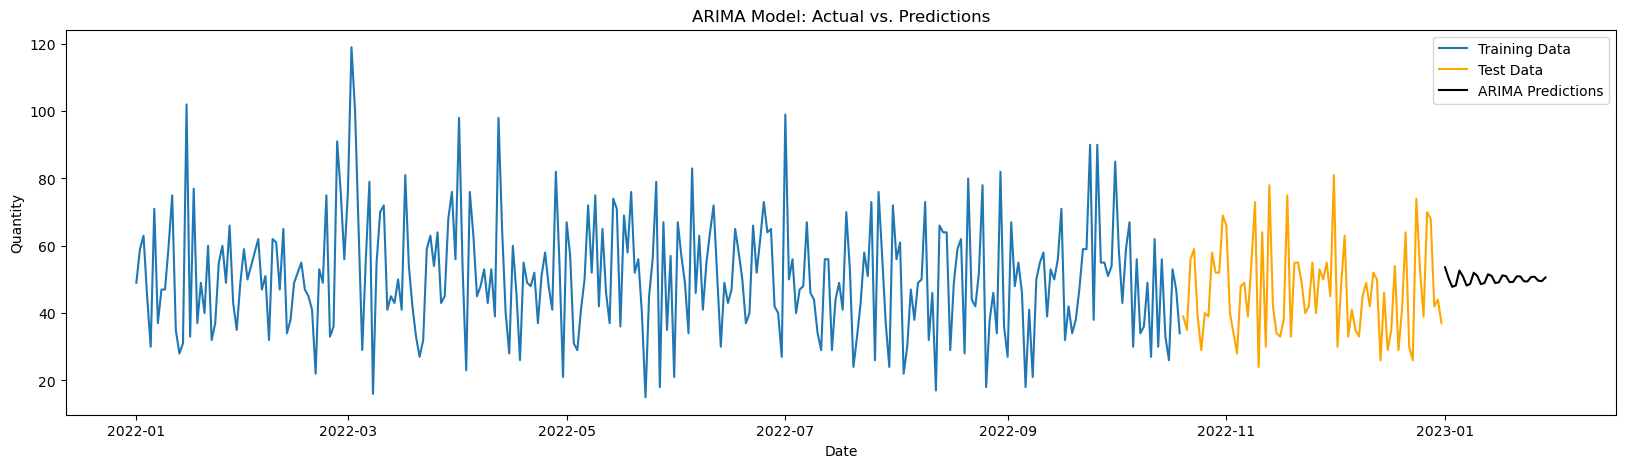

Daily Forecasted Values for the Next 30 Days:
            predictions
2023-01-01    53.607915
2023-01-02    50.326279
2023-01-03    47.808969
2023-01-04    48.199655
2023-01-05    52.639753
2023-01-06    50.863791
2023-01-07    48.193135
2023-01-08    48.681595
2023-01-09    52.000114
2023-01-10    51.030444
2023-01-11    48.585178
2023-01-12    48.954524
2023-01-13    51.541812
2023-01-14    51.036496
2023-01-15    48.928763
2023-01-16    49.137684
2023-01-17    51.197760
2023-01-18    50.975057
2023-01-19    49.212008
2023-01-20    49.279462
2023-01-21    50.933725
2023-01-22    50.888129
2023-01-23    49.438581
2023-01-24    49.399023
2023-01-25    50.729582
2023-01-26    50.794996
2023-01-27    49.616664
2023-01-28    49.503746
2023-01-29    50.571823


In [51]:
# Combine training and test data to fit the model on the entire dataset
y = pd.concat([df_train['Qty'], df_test['Qty']])

# Fit the ARIMA model to the entire dataset
ARIMAmodel = ARIMA(y, order=(4, 0, 4))
ARIMAmodel = ARIMAmodel.fit()

# Forecast for one month (30 days) into the future
n_forecast = 30  # Change this to the number of days you want to forecast

# Make daily forecasts
y_pred = ARIMAmodel.forecast(steps=n_forecast)

# Create an index for the forecasted periods
forecast_index = pd.date_range(start=df_test.index[-1], periods=n_forecast, freq='D', closed='right')

# Create a DataFrame to hold the forecasted values
y_pred_df = pd.DataFrame({'predictions': y_pred}, index=forecast_index)

# Plot the results
plt.figure(figsize=(20, 5))
plt.plot(df_train['Qty'], label='Training Data')
plt.plot(df_test['Qty'], color='orange', label='Test Data')
plt.plot(y_pred_df['predictions'], color='black', label='ARIMA Predictions')
plt.legend()
plt.title('ARIMA Model: Actual vs. Predictions')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.show()

# Display the forecasted values
print("Daily Forecasted Values for the Next", n_forecast, "Days:")
print(y_pred_df)